In [1]:
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts
from torch.utils.data import WeightedRandomSampler
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Local imports
from lattice_utils import (
    MultiFileDataset,
    BinFileDataset,
    xy_hamiltonian,
    corr_2d,
    deformed_corr_2d,
    reweight,
    helicity_modulus,
    mag,
    undeformed_projected_corrs,
)
from stats import bin_bootstrap, bin_bootstrap_2d

from models import UNet, Conv1Layer
from engines import train

In [2]:
from matplotlib import gridspec
from pathlib import Path


def plot_complex_histograms(
    initial,
    final,
    temps,
    bins=50,
    cmap="viridis",
    save_dir=None,
    filename_prefix="temp",
    dpi=200,
    fmt="png",
    close_figs=True,
):
    """
    If `save_dir` is given, saves one figure per row:
      {save_dir}/{filename_prefix}_{row:03d}.{fmt}
    """
    init = np.atleast_2d(np.asarray(initial))
    fin = np.atleast_2d(np.asarray(final))
    if init.shape != fin.shape:
        raise ValueError(f"shape mismatch: {init.shape} vs {fin.shape}")

    if not np.iscomplexobj(init):
        init = init.astype(np.complex128)
    if not np.iscomplexobj(fin):
        fin = fin.astype(np.complex128)

    outdir = None
    if save_dir is not None:
        outdir = Path(save_dir)
        outdir.mkdir(parents=True, exist_ok=True)

    def _plot_pair(initial_row, final_row, row_idx):
        re1, im1 = initial_row.real, initial_row.imag
        re2, im2 = final_row.real, final_row.imag
        mask1 = np.isfinite(re1) & np.isfinite(im1)
        mask2 = np.isfinite(re2) & np.isfinite(im2)
        re1, im1 = re1[mask1], im1[mask1]
        re2, im2 = re2[mask2], im2[mask2]
        if re1.size == 0 or re2.size == 0:
            raise ValueError(f"Row {row_idx}: no finite data after filtering.")

        xmin = min(re1.min(), re2.min())
        xmax = max(re1.max(), re2.max())
        ymin = min(im1.min(), im2.min())
        ymax = max(im1.max(), im2.max())
        if xmin == xmax:
            xmax = xmin + 1.0
        if ymin == ymax:
            ymax = ymin + 1.0
        xr_pad = 1e-9 * max(1.0, abs(xmax - xmin))
        yr_pad = 1e-9 * max(1.0, abs(ymax - ymin))
        xmin -= xr_pad
        xmax += xr_pad
        ymin -= yr_pad
        ymax += yr_pad

        xedges = np.linspace(xmin, xmax, int(bins) + 1)
        yedges = np.linspace(ymin, ymax, int(bins) + 1)

        H1, _, _ = np.histogram2d(re1, im1, bins=[xedges, yedges], density=True)
        H2, _, _ = np.histogram2d(re2, im2, bins=[xedges, yedges], density=True)
        vmax = max(H1.max(), H2.max())
        if not np.isfinite(vmax) or vmax == 0:
            vmax = 1.0

        fig = plt.figure(figsize=(12, 6), constrained_layout=True)
        gs = gridspec.GridSpec(2, 4, figure=fig, height_ratios=[1, 4], width_ratios=[4, 1, 4, 1])

        def draw_panel(re, im, title, xlabel, ylabel, gs_col):
            ax_top = fig.add_subplot(gs[0, gs_col])
            ax_main = fig.add_subplot(gs[1, gs_col])
            ax_right = fig.add_subplot(gs[1, gs_col + 1], sharey=ax_main)

            h = ax_main.hist2d(re, im, bins=[xedges, yedges], cmap=cmap, vmin=0, vmax=vmax, density=True)
            ax_main.set_xlim(xmin, xmax)
            ax_main.set_ylim(ymin, ymax)
            ax_main.set_title(title, pad=8)
            ax_main.set_xlabel(xlabel)
            ax_main.set_ylabel(ylabel)

            ax_top.hist(re, bins=xedges, color="gray", density=True)
            ax_top.set_xlim(xmin, xmax)
            ax_top.tick_params(axis="x", labelbottom=False)
            ax_top.set_ylabel("Density")
            ax_top.spines["right"].set_visible(False)
            ax_top.spines["top"].set_visible(False)

            ax_right.hist(im, bins=yedges, orientation="horizontal", color="gray", density=True)
            ax_right.set_ylim(ymin, ymax)
            ax_right.tick_params(axis="y", labelleft=False)
            ax_right.set_xlabel("Density")
            ax_right.spines["top"].set_visible(False)
            ax_right.spines["right"].set_visible(False)

            mu_re, mu_im = float(np.mean(re)), float(np.mean(im))
            var_re, var_im = float(np.var(re)), float(np.var(im))
            ax_main.axvline(mu_re, color="white", linestyle="--", linewidth=1)
            ax_main.axhline(mu_im, color="white", linestyle="--", linewidth=1)
            ax_main.text(
                0.02,
                0.98,
                f"Var(Re) = {var_re:.3g}\nVar(Im) = {var_im:.3g}",
                transform=ax_main.transAxes,
                va="top",
                ha="left",
                fontsize=9,
                bbox=dict(facecolor="white", alpha=0.7, edgecolor="none", boxstyle="round,pad=0.3"),
            )
            return h, ax_main

        h1, ax_left = draw_panel(re1, im1, "Undeformed correlator", "Re(O)", "Im(O)", 0)
        h2, ax_right = draw_panel(re2, im2, "Deformed correlator", "Re(Q)", "Im(Q)", 2)
        cbar = fig.colorbar(h2[3], ax=[ax_left, ax_right], orientation="vertical", pad=0.02)
        cbar.set_label("Density")
        fig.suptitle(f"Temperature {temps[row_idx]}", y=1.02, fontsize=12)

        if outdir is not None:
            fname = f"{filename_prefix}_{row_idx}.{fmt}"
            fig.savefig(outdir / fname, dpi=dpi, bbox_inches="tight")
        if close_figs:
            plt.close(fig)

    for r in range(init.shape[0]):
        _plot_pair(init[r], fin[r], r)

### To-dos
- Show improvement due to 1 layer network using histograms
- Bootstrap errors on helicity modulus, magnetization, and heat capacity
- Bootstrap errors on undeformed projected correlation
- Bootstrap errors on deformed projected/unprojected correlation
- Compare variance against separation for both

In [3]:
print(torch.__version__)
print(torch.cuda.get_device_name(0))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

2.6.0+rocm6.4.1.git1ded221d
AMD Radeon™ RX 7700S


In [4]:
kernel_size = 21
lat_size = 128

In [5]:
train_multi_file_ds = MultiFileDataset(folder="L_128/U-Net/train")
val_multi_file_ds = MultiFileDataset(folder="L_128/U-Net/val")

### Basic Observables

In [6]:
helicity_moduli = []
mags = []
energies = []

for i in range(len(train_multi_file_ds.datasets)):
    print(f"Dataset {i + 1}/{len(train_multi_file_ds.datasets)}")

    ds = train_multi_file_ds.datasets[i]
    temp = torch.tensor([ds.T], dtype=torch.float32, device=device)
    loader = DataLoader(ds, batch_size=128, shuffle=False)

    helicity_modulus_samples = []
    mag_samples = []
    energy_samples = []

    for batch, inputs in enumerate(loader):
        inputs = tuple(x.to(device) for x in inputs)
        lats = inputs[0]
        helicity_modulus_samples.append(helicity_modulus(lats, temp).cpu().numpy())
        mag_samples.append(mag(lats).cpu().numpy())
        energy_samples.append(xy_hamiltonian(lats).cpu().numpy())

    helicity_moduli.append(np.concat(helicity_modulus_samples, axis=0))
    mags.append(np.concat(mag_samples, axis=0))
    energies.append(np.concat(energy_samples, axis=0))

Dataset 1/41
Dataset 2/41
Dataset 3/41
Dataset 4/41
Dataset 5/41
Dataset 6/41
Dataset 7/41
Dataset 8/41
Dataset 9/41
Dataset 10/41
Dataset 11/41
Dataset 12/41
Dataset 13/41
Dataset 14/41
Dataset 15/41
Dataset 16/41
Dataset 17/41
Dataset 18/41
Dataset 19/41
Dataset 20/41
Dataset 21/41
Dataset 22/41
Dataset 23/41
Dataset 24/41
Dataset 25/41
Dataset 26/41
Dataset 27/41
Dataset 28/41
Dataset 29/41
Dataset 30/41
Dataset 31/41
Dataset 32/41
Dataset 33/41
Dataset 34/41
Dataset 35/41
Dataset 36/41
Dataset 37/41
Dataset 38/41
Dataset 39/41
Dataset 40/41
Dataset 41/41


In [7]:
helicity_moduli = np.stack(helicity_moduli)
mags = np.stack(np.abs(mags))
energies = np.stack(energies)

In [8]:
train_temps = np.array([ds.T for ds in train_multi_file_ds.datasets])
val_temps = np.array([ds.T for ds in val_multi_file_ds.datasets])

In [9]:
# np.save("obs/helicity_moduli.npy", helicity_moduli)
# np.save("obs/mags.npy", mags)
# np.save("obs/energies.npy", energies)

In [10]:
def bootstrap_obs(n_temps, obs, stat=np.mean):
    means = []
    lower_bounds = []
    upper_bounds = []

    for i in range(n_temps):
        mean, lower_bound, upper_bound, iact = bin_bootstrap(obs[i], stat, 100, 95)
        means.append(mean)
        lower_bounds.append(lower_bound)
        upper_bounds.append(upper_bound)
        print(iact)

    return np.array(means), np.array(lower_bounds), np.array(upper_bounds)

In [11]:
hm_errs = bootstrap_obs(41, helicity_moduli)
susc_errs = bootstrap_obs(41, mags / np.sqrt(train_temps[:, None]), stat=np.var)
spheat_errs = bootstrap_obs(41, energies / (train_temps[:, None] * lat_size), stat=np.var)

1.1412543410193277
1.1023737569991399
1.0923644604846288
1.1157264909467592
1.066533762790036
1.1050212563380535
1.0662253108484132
1.0111592491826606
1.0619874444684008
1.0565693754356729
1.060801971174589
1.1383480713716887
0.9430407510265044
1.070516907071379
0.9664655820508901
1.0265198180793438
1.1197051977683572
1.146788005184535
1.0589383440643407
1.076507438155867
1.0399580813508111
0.9849161225009015
1.0924834751222947
0.9864485997200745
1.0157828081697386
0.9940889787616491
1.0622007911849958
1.0698979649459657
1.2496755279895886
1.2075754897116247
1.3938237480801092
1.450224411365737
1.751895041754595
2.096910536528391
2.4566161198517125
3.021620340319454
3.7312711427489087
4.7060779763388165
4.544535002171466
6.1642618765523896
7.13060672583271
1.5922893398955897
1.551737909733153
1.4968265054889527
1.362966330393805
1.4375849219798014
1.4576906555411069
1.496275696273362
1.4942849369040232
1.314749617953148
1.4365864145536733
1.5618882308309654
1.2995254416181397
1.1576245

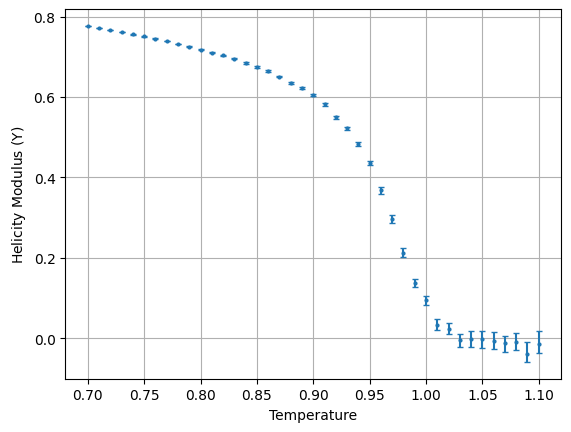

In [12]:
plt.errorbar(
    train_temps,
    hm_errs[0],
    yerr=(hm_errs[0] - hm_errs[1], hm_errs[2] - hm_errs[0]),
    fmt="o",
    markersize=2,  # size of the mean point
    capsize=2.5,  # caps at ends of error bars
    elinewidth=1.5,  # vertical line thickness
    capthick=1,  # cap thickness
)
# plt.title("Helicity Modulus")
plt.xlabel("Temperature")
plt.ylabel("Helicity Modulus ($\\Upsilon$)")
plt.grid()

Text(0, 0.5, 'Susceptibility ($\\chi$)')

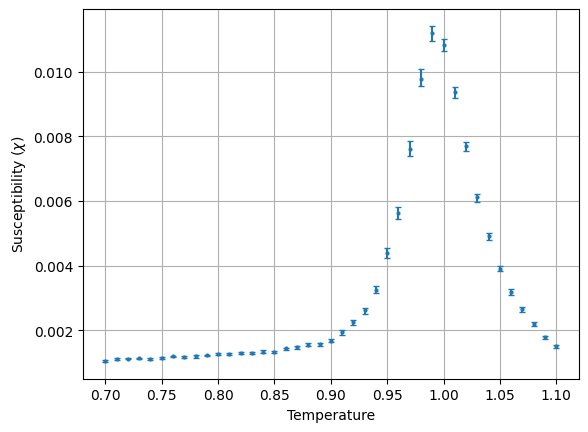

In [13]:
plt.errorbar(
    train_temps,
    susc_errs[0],
    yerr=(susc_errs[0] - susc_errs[1], susc_errs[2] - susc_errs[0]),
    fmt="o",
    markersize=2,
    capsize=2.5,
    elinewidth=1.5,
    capthick=1,
)
plt.grid()
plt.xlabel("Temperature")
plt.ylabel("Susceptibility ($\\chi$)")

Text(0, 0.5, 'Specific Heat ($c$)')

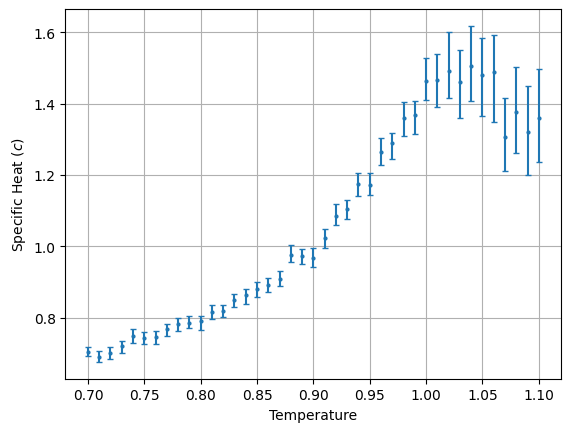

In [14]:
plt.errorbar(
    train_temps,
    spheat_errs[0],
    yerr=(spheat_errs[0] - spheat_errs[1], spheat_errs[2] - spheat_errs[0]),
    fmt="o",
    markersize=2,
    capsize=2.5,
    elinewidth=1.5,
    capthick=1,
)
plt.grid()
plt.xlabel("Temperature")
plt.ylabel("Specific Heat ($c$)")

### 1-Layer Convolutional Network

In [23]:
temps_range = np.arange(0.8, 1.01, 0.01)

loaders = []

for temp in temps_range:
    fname = f"L=128_cluster_T={temp:.4f}_configs.bin"
    train_folder = "L_128/U-Net/train"
    val_folder = "L_128/U-Net/val"

    train_ds = BinFileDataset(folder=train_folder, fname=fname, seps=(lat_size // 2, lat_size // 2), random_seps=False)
    val_ds = BinFileDataset(folder=val_folder, fname=fname, seps=(lat_size // 2, lat_size // 2), random_seps=False)

    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, pin_memory=True, drop_last=True)
    val_loader = DataLoader(val_ds, batch_size=4096, shuffle=False, pin_memory=True, drop_last=False)

    loaders.append((train_loader, val_loader))

In [ ]:
undef_1layer = []
def_1layer = []

conv1layer = Conv1Layer(lat_size=lat_size, kernel_size=kernel_size)

for i in range(len(loaders)):

    single_loader, single_val_loader = loaders[i]

    conv1layer.to(device)

    optim = Adam(conv1layer.parameters(), lr=1e-3)
    # scheduler = CosineAnnealingLR(optim, 25, 1e-5)

    epochs = 1
    if i == 0:
        epochs = 30

    train(
        model=conv1layer,
        loader=single_loader,
        optimizer=optim,
        # scheduler=scheduler,
        epochs=epochs,
        device=device,
        val_loader=single_val_loader,
    )

    def_samples = []
    undef_samples = []

    with torch.no_grad():
        conv1layer.eval()

        for batch, inputs in enumerate(single_val_loader):
            inputs = tuple(x.to(device) for x in inputs)
            lats, temp, x, y = inputs

            shifts = conv1layer(temp, x, y)

            deformed_corr = deformed_corr_2d(lats, temp, shifts, x, y)
            corr = corr_2d(lats, x, y)

            def_samples.append(deformed_corr.cpu().detach().numpy())
            undef_samples.append(corr.cpu().detach().numpy())

    def_1layer.append(np.concatenate(def_samples, axis=0))
    undef_1layer.append(np.concatenate(undef_samples, axis=0))

def_1layer = np.stack(def_1layer)
undef_1layer = np.stack(undef_1layer)

In [ ]:
# np.save("corrs/1layer/deformed_corrs.npy", def_1layer)
# np.save("corrs/1layer/undeformed_corrs.npy", undef_1layer)

In [6]:
undef_1layer = np.load("corrs/1layer/undeformed_corrs.npy")
def_1layer = np.load("corrs/1layer/deformed_corrs.npy")

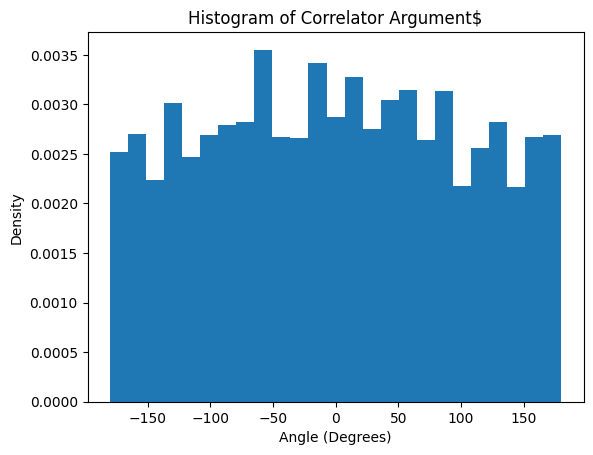

In [ ]:
import matplotlib.ticker as ticker

angles = np.angle(undef_1layer[-1])
plt.hist(180 * angles / np.pi, bins=25, density=True)
plt.xlabel("Angle (Degrees)")
plt.ylabel("Density")
plt.title("Histogram of Correlator Argument$")

plt.show()

In [ ]:
plot_complex_histograms(
    undef_1layer[::10],
    def_1layer[::10],
    temps=np.round(temps_range[::10], decimals=2),
    bins=50,
    cmap="viridis",
    save_dir="writeup/figures/1layer_hists",
)

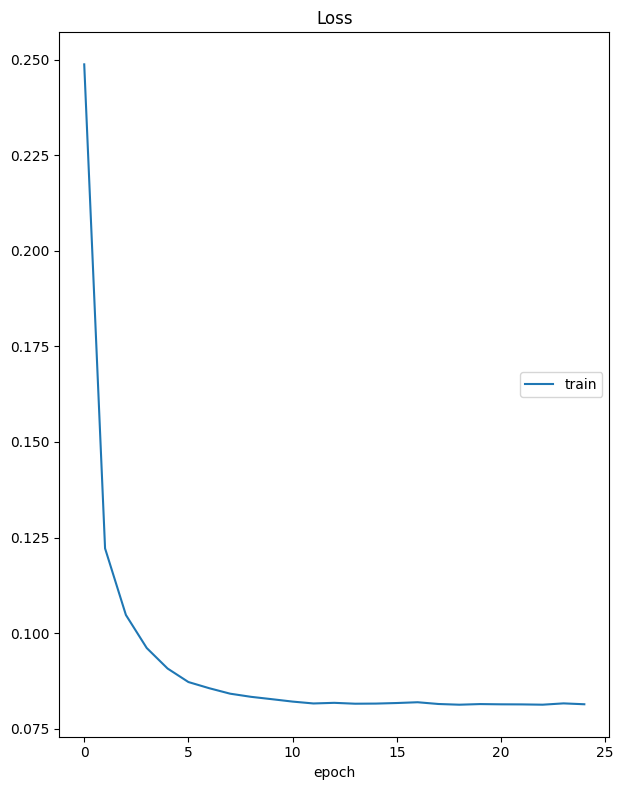

Loss
	train            	 (min:    0.081, max:    0.249, cur:    0.081)


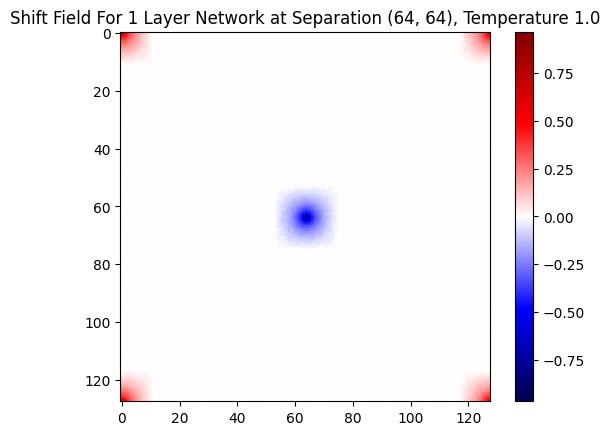

In [ ]:
conv1layer = Conv1Layer(128, kernel_size=kernel_size).to(device)
train(conv1layer, device, loaders[-1][0], Adam(conv1layer.parameters(), lr=2e-3), 25)

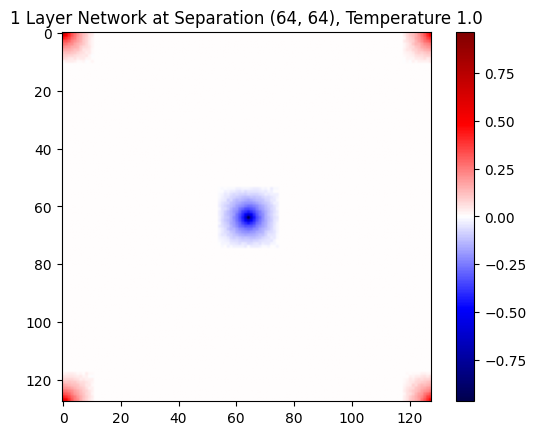

In [ ]:
conv1layer.eval()
with torch.no_grad():
    shift_field = conv1layer(
        torch.tensor([1.0], device=device, dtype=torch.float32),
        torch.tensor([lat_size // 2], device=device, dtype=torch.float32),
        torch.tensor([lat_size // 2], device=device, dtype=torch.float32),
    )
    plt.imshow(shift_field.squeeze().cpu().detach().numpy(), cmap="seismic")
    plt.title("1 Layer Network at Separation (64, 64), Temperature 1.0")
    plt.colorbar()

**U-Net architecture for temperation and separation generalization**

Separation allowed to vary over the full lattice, and a set temperatures is used for training

Consider boltzmann reweighting to interpolate between temperatures?

Loss function:
$$\frac{1}{L^2}\sum_{\mathbf{x}\in\Lambda}\int_{t_0}^{t_1}dt\,\rho(t) \cdot \mathcal{L}\left[\Delta(\mathbf{x},t);\,\mathbf{x},t \right]$$

$$\mathcal{L}\left[\Delta(\mathbf{x},t);\,\mathbf{x},t \right] = \left[\mathrm{Re}\left\langle \mathcal{Q(\mathbf{x},t)} \right\rangle\right]^2$$

$$\mathcal{Q}(\mathbf{x},t)=\exp\left[i(\tilde{\theta}(\mathbf{x},t) - \tilde{\theta}(\mathbf{0},t))\right]\cdot\exp\left[{-\beta(H(\tilde{\Omega})-H(\Omega))}\right]$$

$$\Omega=\left\{\theta(\mathbf{x}) | \mathbf{x}\in \Lambda\right\},\, \tilde{\theta}(\mathbf{x}) = \theta(\mathbf{x},t) + i\Delta(\mathbf{x,t})$$

With $\rho(t)$ some probability density that has support over $[t_0,t_1]$. Currently using a uniform sampling in $\beta$ rather than $t$, which amounts to the change of variables $d\beta=-dT/T^2$

In [7]:
unet = UNet(lat_size=128, min_size=4)
unet.to(device)
unet.load_state_dict(torch.load("unet_state_dict_128.pth"))  # With min size 4
# unet.load_state_dict(torch.load("unet_state_dict_128_min_16.pth"))  # With min size 16

<All keys matched successfully>

In [ ]:
training_sample_weights = reweight(
    torch.stack([train_multi_file_ds[i][1] for i in range(len(train_multi_file_ds))]).detach().numpy(),
    dist=lambda x: x**-2,
)

np.save("L_128/U-Net/train_sample_weights.npy", training_sample_weights)

In [6]:
training_sample_weights = np.load("L_128/U-Net/train_sample_weights.npy")
sampler = WeightedRandomSampler(training_sample_weights, num_samples=len(train_multi_file_ds), replacement=True)

In [7]:
multi_train_loader = DataLoader(train_multi_file_ds, batch_size=64, pin_memory=True, sampler=sampler)
multi_val_loader = DataLoader(val_multi_file_ds, batch_size=256, shuffle=False, pin_memory=True)

optim = Adam(unet.parameters(), lr=1e-3)
# scheduler = CosineAnnealingWarmRestarts(optim, 2500, eta_min=1e-5)

In [8]:
from torchinfo import summary

summary(unet, input_data=tuple(i.to(device) for i in next(iter(multi_val_loader))[1:]))

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [256, 128, 128]           --
├─ModuleList: 1-21                       --                        (recursive)
│    └─Conv2d: 2-1                       [256, 2, 128, 128]        20
├─ModuleList: 1-22                       --                        (recursive)
│    └─Sequential: 2-2                   [256, 4]                  --
│    │    └─Linear: 3-1                  [256, 2]                  4
│    │    └─SiLU: 3-2                    [256, 2]                  --
│    │    └─Linear: 3-3                  [256, 4]                  12
│    │    └─SiLU: 3-4                    [256, 4]                  --
├─ModuleList: 1-38                       --                        (recursive)
│    └─Conv2d: 2-3                       [256, 2, 128, 128]        38
├─MaxPool2d: 1-4                         [256, 2, 64, 64]          --
├─ModuleList: 1-21                       --                

In [ ]:
unet.train()

train(
    model=unet,
    loader=multi_train_loader,
    optimizer=optim,
    # scheduler=scheduler,
    epochs=20,
    device=device,
    val_loader=multi_val_loader,
)

In [ ]:
# torch.save(unet.state_dict(), "unet_state_dict_128_min_16.pth")

### Post Processing of Data

In [ ]:
init_corrs, def_corrs = torch.load("corrs_128.pth")

In [9]:
x_seps = np.arange(lat_size // 4, 3 * lat_size // 4 + 1, 4)  # every 4th separation for efficiency
y_seps = np.arange(lat_size // 4, 3 * lat_size // 4 + 1, 4)  # every 4th separation for efficiency

In [23]:
unet.eval()

k = torch.tensor([lat_size // 2], device=device, dtype=torch.float32)
j = torch.tensor([lat_size // 2], device=device, dtype=torch.float32)

tempwise_shift_fields = []

temps_range = np.linspace(0.8, 1.0, 21)

for T in temps_range:

    print(f"Processing temperature: {T}")

    with torch.no_grad():

        temp = torch.tensor([T], device=device, dtype=torch.float32)

        initial = []
        deformed = []

        shift_field = unet(temp, k, j)

        tempwise_shift_fields.append(shift_field.cpu())

tempwise_shift_fields = torch.cat(tempwise_shift_fields, dim=0)
tempwise_shift_fields_centred = tempwise_shift_fields - tempwise_shift_fields.mean(dim=(1, 2), keepdim=True)

Processing temperature: 0.8
Processing temperature: 0.81
Processing temperature: 0.8200000000000001
Processing temperature: 0.8300000000000001
Processing temperature: 0.8400000000000001
Processing temperature: 0.8500000000000001
Processing temperature: 0.86
Processing temperature: 0.87
Processing temperature: 0.88
Processing temperature: 0.89
Processing temperature: 0.9
Processing temperature: 0.91
Processing temperature: 0.92
Processing temperature: 0.93
Processing temperature: 0.9400000000000001
Processing temperature: 0.95
Processing temperature: 0.96
Processing temperature: 0.97
Processing temperature: 0.98
Processing temperature: 0.99
Processing temperature: 1.0


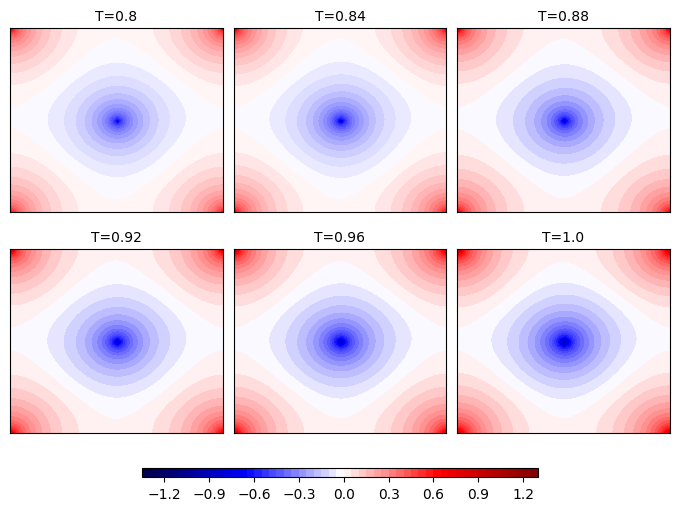

In [ ]:
from matplotlib import colors


def plot_tensor_grid_contours(tensor, temps, levels=21):
    """
    Plot a grid of filled-contour slices from a (N, L, L) tensor.

    Args:
        tensor: PyTorch tensor of shape (N, L, L)
        temps: iterable of length N, labels for each slice
        levels: int or sequence, number of contour levels or explicit levels
    """
    assert tensor.ndim == 3, "Input tensor must have shape (N, L, L)"
    N, L1, L2 = tensor.shape
    assert L1 == L2, "Each slice must be square (L, L)"
    assert len(temps) == N, "len(temps) must equal N"

    # Convert to numpy
    array = tensor.detach().cpu().numpy()

    # Determine grid size
    ncols = int(np.ceil(np.sqrt(N)))
    nrows = int(np.ceil(N / ncols))

    # Create figure and subplots with minimal gaps
    fig, axes = plt.subplots(
        nrows,
        ncols,
        figsize=(2.2 * ncols, 2.2 * nrows),
        sharex=False,
        sharey=False,
        gridspec_kw=dict(wspace=0.05, hspace=0.2),
    )

    # Flatten axes safely even if nrows==ncols==1
    axes = np.atleast_1d(axes).ravel()

    # Common color scale
    vmin = float(array.min())
    vmax = float(array.max())
    norm = colors.Normalize(vmin=vmin, vmax=vmax)

    cf = None
    for i in range(N):
        cf = axes[i].contourf(array[i], levels=levels, cmap="seismic", norm=norm, origin="upper")
        axes[i].set_title(f"T={temps[i]}", fontsize=10)
        axes[i].set_xticks([])
        axes[i].set_yticks([])

    # Hide any extra axes
    for i in range(N, len(axes)):
        axes[i].axis("off")

    # Horizontal colorbar (under the grid)
    cbar_ax = fig.add_axes([0.2, -0.02, 0.6, 0.02])  # x, y, width, height
    fig.colorbar(cf, cax=cbar_ax, orientation="horizontal")

    plt.subplots_adjust(left=0, right=1, top=1, bottom=0.08)
    plt.show()


tensor = tempwise_shift_fields_centred[::4]
plot_tensor_grid_contours(tensor, np.round(temps_range[::4], 2), levels=51)

In [ ]:
def plot_tensor_grid_3d(tensor, stride=1):
    assert tensor.ndim == 3, "Input tensor must have shape (N, L, L)"
    N, L1, L2 = tensor.shape
    assert L1 == L2, "Each slice must be square (L, L)"

    array = tensor.detach().cpu().numpy()

    # Downsample if needed
    array = array[::stride]
    N = array.shape[0]

    # Determine grid size
    ncols = int(np.ceil(np.sqrt(N)))
    nrows = int(np.ceil(N / ncols))

    fig = plt.figure(figsize=(3.5 * ncols, 3.5 * nrows))

    # Coordinate grid
    x = np.arange(L1)
    y = np.arange(L2)
    X, Y = np.meshgrid(x, y)

    vmin = array.min()
    vmax = array.max()

    for i in range(N):
        ax = fig.add_subplot(nrows, ncols, i + 1, projection="3d")
        ax.plot_surface(X, Y, array[i], cmap="seismic", vmin=vmin, vmax=vmax, linewidth=0, antialiased=False)
        ax.set_zlim(vmin, vmax)
        # ax.axis('off')  # optional: remove axes

        ax.view_init(elev=10, azim=60)

    # plt.tight_layout()
    plt.show()


tensor = tempwise_shift_fields_centred[::3]
plot_tensor_grid_3d(tensor)

In [15]:
val_temps = np.array([ds.T for ds in val_multi_file_ds.datasets])
x_seps = np.arange(lat_size // 4, 3 * lat_size // 4 + 1, 4)  # every 4th separation for efficiency
y_seps = np.arange(lat_size)

In [16]:
with torch.no_grad():

    batch_size = 100

    undeformed_proj = []

    for k in range(len(val_multi_file_ds.datasets)):
        print(f"Dataset {k + 1}/{len(val_multi_file_ds.datasets)}")

        ds = val_multi_file_ds.datasets[k]

        loader = DataLoader(ds, batch_size=batch_size, shuffle=False)

        samples = []

        for batch, inputs in enumerate(loader):

            inputs = tuple(inp.to(device) for inp in inputs)
            lats = inputs[0]

            samples.append(undeformed_projected_corrs(lats, x_seps))

        samples = np.concatenate(samples, axis=0)
        undeformed_proj.append(samples)

    undeformed_proj = np.stack(undeformed_proj) / lat_size

undeformed_proj.shape

Dataset 1/21
Dataset 2/21
Dataset 3/21
Dataset 4/21
Dataset 5/21
Dataset 6/21
Dataset 7/21
Dataset 8/21
Dataset 9/21
Dataset 10/21
Dataset 11/21
Dataset 12/21
Dataset 13/21
Dataset 14/21
Dataset 15/21
Dataset 16/21
Dataset 17/21
Dataset 18/21
Dataset 19/21
Dataset 20/21
Dataset 21/21


(21, 4500, 17)

In [17]:
undeformed_proj_mean_CIs = []
undeformed_proj_var_CIs = []

for i in range(undeformed_proj.shape[0]):
    print(f"Bootstrapping temperature {i + 1}/{undeformed_proj.shape[0]}")

    mean_CIs = bin_bootstrap_2d(undeformed_proj[i], np.mean, 1, 200, 95)
    var_CIs = bin_bootstrap_2d(undeformed_proj[i], np.var, 1, 200, 95)

    undeformed_proj_mean_CIs.append(mean_CIs)
    undeformed_proj_var_CIs.append(var_CIs)

Bootstrapping temperature 1/21
Bootstrapping temperature 2/21
Bootstrapping temperature 3/21
Bootstrapping temperature 4/21
Bootstrapping temperature 5/21
Bootstrapping temperature 6/21
Bootstrapping temperature 7/21
Bootstrapping temperature 8/21
Bootstrapping temperature 9/21
Bootstrapping temperature 10/21
Bootstrapping temperature 11/21
Bootstrapping temperature 12/21
Bootstrapping temperature 13/21
Bootstrapping temperature 14/21
Bootstrapping temperature 15/21
Bootstrapping temperature 16/21
Bootstrapping temperature 17/21
Bootstrapping temperature 18/21
Bootstrapping temperature 19/21
Bootstrapping temperature 20/21
Bootstrapping temperature 21/21


In [19]:
undeformed_proj_mean_CIs[-1]

(array([9.56280899, 8.91040993, 8.35266018, 7.89355803, 7.52620125,
        7.23026323, 7.0187583 , 6.89469004, 6.85716057, 6.89469004,
        7.0187583 , 7.23026323, 7.52620125, 7.89355803, 8.35266018,
        8.91040993, 9.56280899]),
 array([9.24555357, 8.59059303, 8.08717787, 7.59826334, 7.24911182,
        6.9335187 , 6.73104758, 6.60079157, 6.55035055, 6.60478804,
        6.66525927, 6.89451751, 7.17944947, 7.62306068, 8.09346504,
        8.64333305, 9.29022191]),
 array([9.81894636, 9.17147655, 8.61456537, 8.1479147 , 7.84983371,
        7.52770871, 7.3535051 , 7.18816704, 7.18073499, 7.2719308 ,
        7.38617578, 7.54045358, 7.85570332, 8.12225217, 8.61019766,
        9.15139005, 9.83037193]),
 array([2.10451385, 2.02069477, 1.95386142, 1.89241782, 1.85483608,
        1.83407495, 1.83113269, 1.82874662, 1.81328943, 1.82874665,
        1.83113265, 1.83407493, 1.85483612, 1.89241787, 1.95386141,
        2.02069474, 2.10451384]))

In [ ]:
# np.save(
#     "undeformed_proj_128.npy",
#     undeformed_proj / lat_size,
# )

In [ ]:
x_seps = np.arange(lat_size // 4, 3 * lat_size // 4 + 1, 4)  # every 4th separation for efficiency

with torch.no_grad():

    # batch_size = 2048

    deformed_grid = []

    for k in range(len(val_multi_file_ds.datasets)):
        print(f"Dataset {k + 1}/{len(val_multi_file_ds.datasets)}")

        ds = val_multi_file_ds.datasets[k]
        T = torch.tensor([ds.T], device=device, dtype=torch.float32)

        loader = DataLoader(ds, batch_size=len(ds) // 10, shuffle=False)

        samples = []

        for batch, inputs in enumerate(loader):

            inputs = tuple(inp.to(device) for inp in inputs)
            lats = inputs[0]
            # print(lats.shape)

            grid = np.zeros((lats.size(0), lat_size, x_seps.size), dtype=np.complex64)

            for i in range(lat_size):
                y = torch.tensor([i], device=device, dtype=torch.float32)

                for j in range(x_seps.size):

                    x = torch.tensor([x_seps[j]], device=device, dtype=torch.float32)

                    # Get the shift field for the current temperature and separations
                    shift_field = unet(T, x, y)
                    # deformed_corr = deformed_corr_2d(lats, T, shift_field, x, y)
                    deformed_corr = 0

                    n_sample = 4
                    # Collect points at randomly sampled translations
                    for k in range(n_sample):
                        x0, y0 = np.random.randint(0, lat_size, size=2)
                        # print(x0, y0)
                        deformed_corr += deformed_corr_2d(
                            lats.roll(shifts=(-y0, -x0), dims=(-2, -1)), T, shift_field, x, y
                        )

                    deformed_corr /= n_sample

                    grid[:, i, j] = deformed_corr.cpu().numpy()

            print(f"batch {batch+1}/{len(loader)}", grid.shape)
            samples.append(grid)

        samples = np.concatenate(samples, axis=0)
        print(samples.shape)
        deformed_grid.append(samples)

deformed_grid = np.stack(deformed_grid)

Dataset 1/21
batch 1/10 (450, 128, 17)
batch 2/10 (450, 128, 17)
batch 3/10 (450, 128, 17)
batch 4/10 (450, 128, 17)
batch 5/10 (450, 128, 17)
batch 6/10 (450, 128, 17)
batch 7/10 (450, 128, 17)
batch 8/10 (450, 128, 17)
batch 9/10 (450, 128, 17)
batch 10/10 (450, 128, 17)
(4500, 128, 17)
Dataset 2/21
batch 1/10 (450, 128, 17)
batch 2/10 (450, 128, 17)
batch 3/10 (450, 128, 17)
batch 4/10 (450, 128, 17)
batch 5/10 (450, 128, 17)
batch 6/10 (450, 128, 17)
batch 7/10 (450, 128, 17)
batch 8/10 (450, 128, 17)
batch 9/10 (450, 128, 17)
batch 10/10 (450, 128, 17)
(4500, 128, 17)
Dataset 3/21
batch 1/10 (450, 128, 17)
batch 2/10 (450, 128, 17)
batch 3/10 (450, 128, 17)
batch 4/10 (450, 128, 17)
batch 5/10 (450, 128, 17)
batch 6/10 (450, 128, 17)
batch 7/10 (450, 128, 17)
batch 8/10 (450, 128, 17)
batch 9/10 (450, 128, 17)
batch 10/10 (450, 128, 17)
(4500, 128, 17)
Dataset 4/21
batch 1/10 (450, 128, 17)
batch 2/10 (450, 128, 17)
batch 3/10 (450, 128, 17)
batch 4/10 (450, 128, 17)
batch 5/10 (4

In [20]:
deformed_grid = np.load("deformed_grid_128_x4_sampling.npy")
# deformed_grid = np.load("deformed_grid_128.npy")

In [24]:
deformed_proj = deformed_grid.sum(axis=-2).real

In [25]:
deformed_proj_mean_CIs = []
deformed_proj_var_CIs = []

for i in range(deformed_proj.shape[0]):
    print(f"Bootstrapping temperature {i + 1}/{deformed_proj.shape[0]}")

    mean_CIs = bin_bootstrap_2d(deformed_proj[i], np.mean, 1, 200, 95)
    var_CIs = bin_bootstrap_2d(deformed_proj[i], np.var, 1, 200, 95)

    deformed_proj_mean_CIs.append(mean_CIs)
    deformed_proj_var_CIs.append(var_CIs)

Bootstrapping temperature 1/21
Bootstrapping temperature 2/21
Bootstrapping temperature 3/21
Bootstrapping temperature 4/21
Bootstrapping temperature 5/21
Bootstrapping temperature 6/21
Bootstrapping temperature 7/21
Bootstrapping temperature 8/21
Bootstrapping temperature 9/21
Bootstrapping temperature 10/21
Bootstrapping temperature 11/21
Bootstrapping temperature 12/21
Bootstrapping temperature 13/21
Bootstrapping temperature 14/21
Bootstrapping temperature 15/21
Bootstrapping temperature 16/21
Bootstrapping temperature 17/21
Bootstrapping temperature 18/21
Bootstrapping temperature 19/21
Bootstrapping temperature 20/21
Bootstrapping temperature 21/21


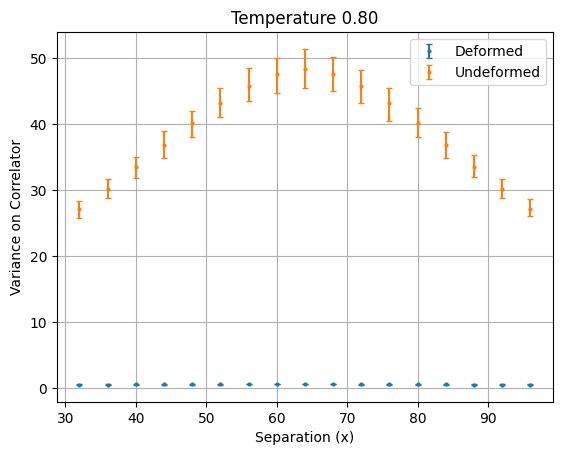

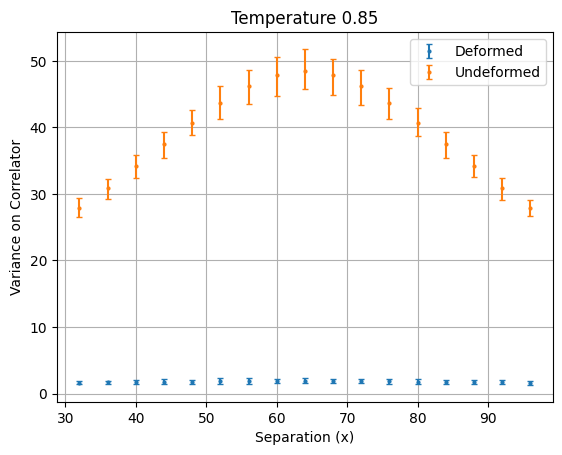

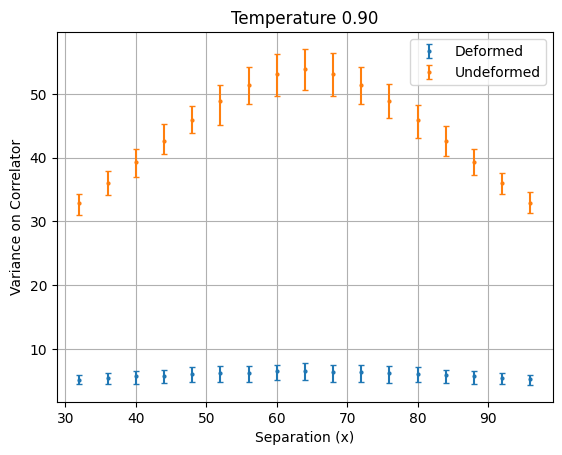

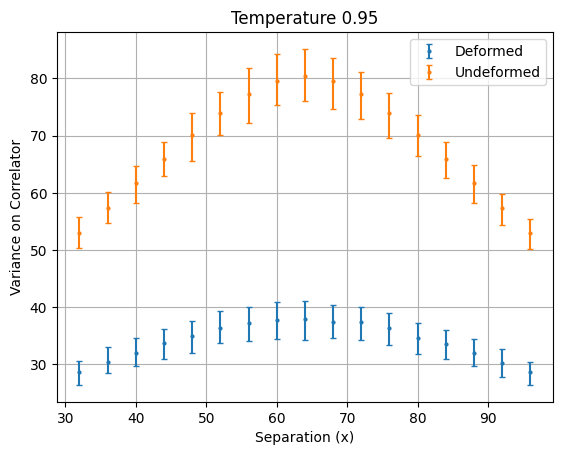

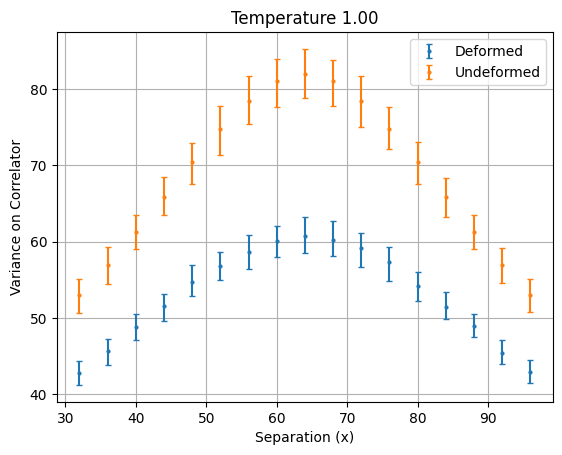

In [106]:
for i in range(0,21,5):
    plt.figure()
    c, l, u, _ = deformed_proj_var_CIs[i]
    plt.errorbar(
        x_seps,
        c,
        yerr=(c - l, u - c),
        fmt="o",
        markersize=2,  # size of the mean point
        capsize=2.5,  # caps at ends of error bars
        elinewidth=1.5,  # vertical line thickness
        capthick=1,  # cap thickness
        label='Deformed'
    )

    c, l, u, _ = undeformed_proj_var_CIs[i]
    plt.errorbar(
        x_seps,
        c,
        yerr=(c - l, u - c),
        fmt="o",
        markersize=2,  # size of the mean point
        capsize=2.5,  # caps at ends of error bars
        elinewidth=1.5,  # vertical line thickness
        capthick=1,  # cap thickness
        label='Undeformed'
    )
    plt.grid()
    plt.xlabel('Separation (x)')
    plt.ylabel('Variance on Correlator')
    plt.title(f'Temperature {val_temps[i]:.2f}')
    plt.legend()
    plt.savefig(f"writeup/figures/deformed_vs_undeformed_var/fig_{i//5}.png", dpi=200, bbox_inches="tight")

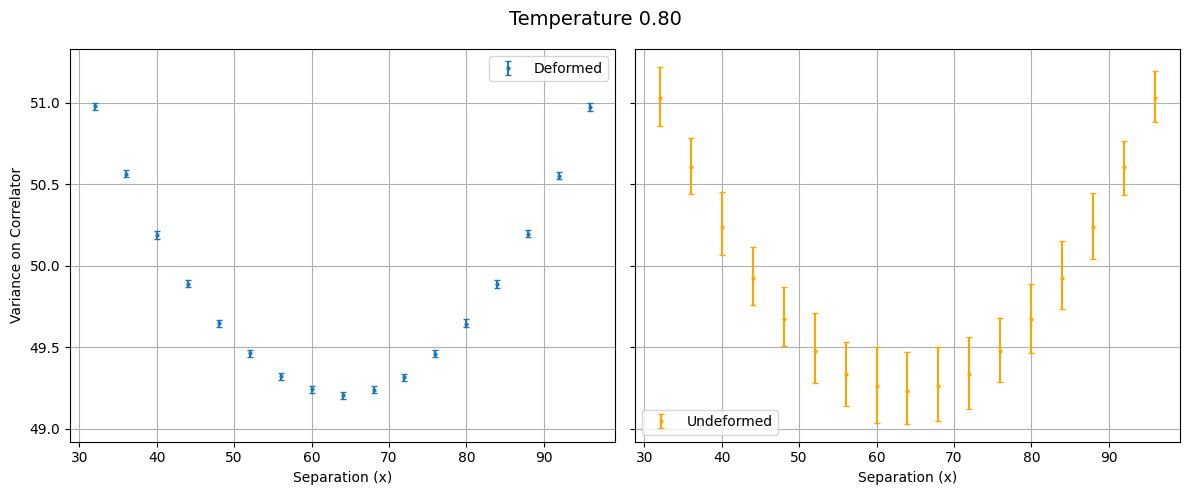

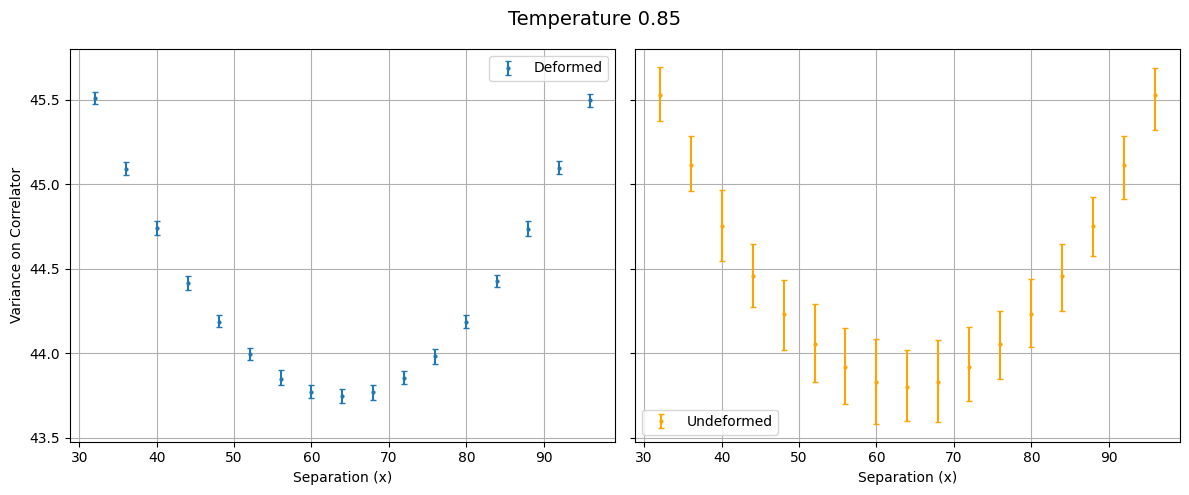

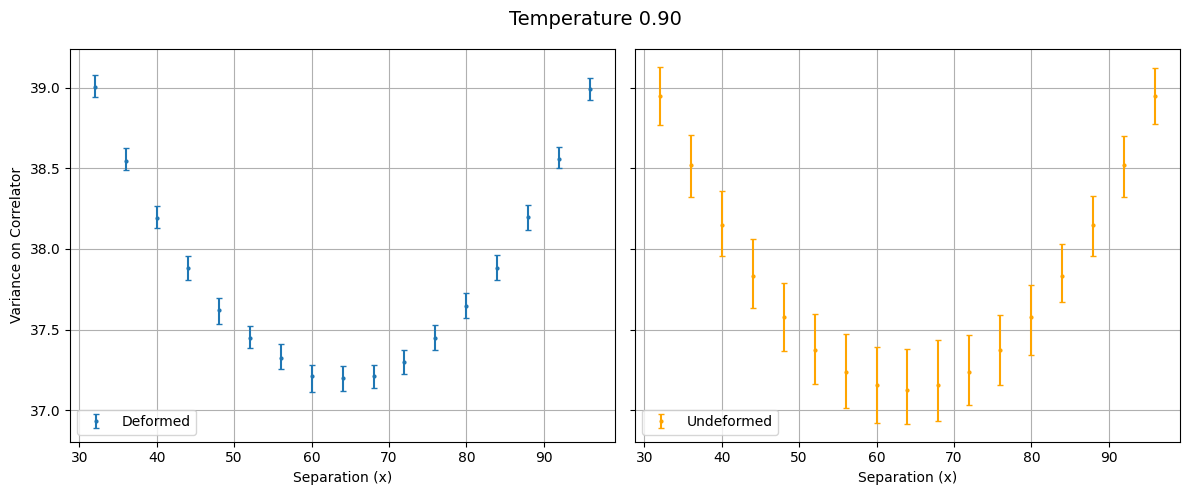

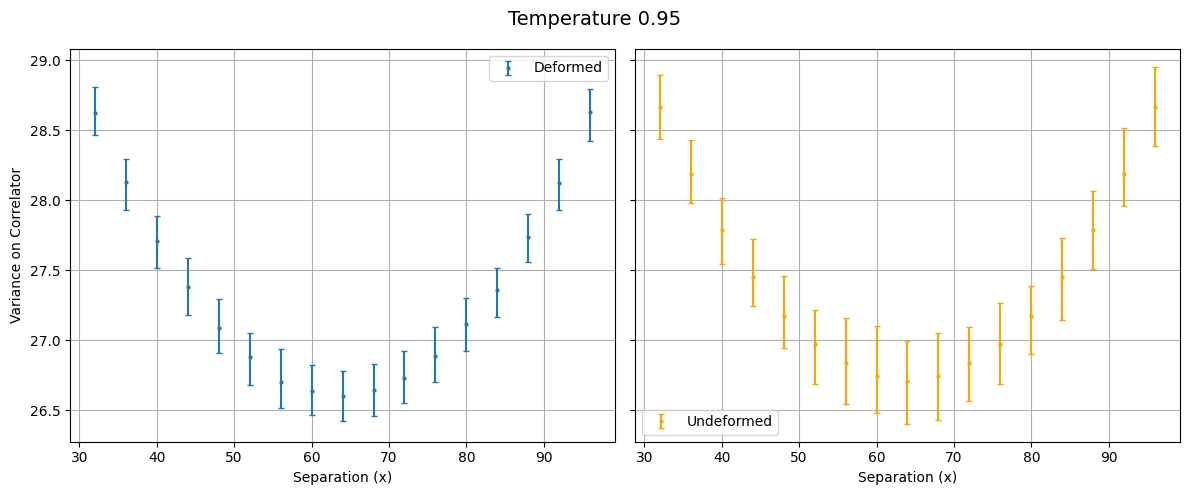

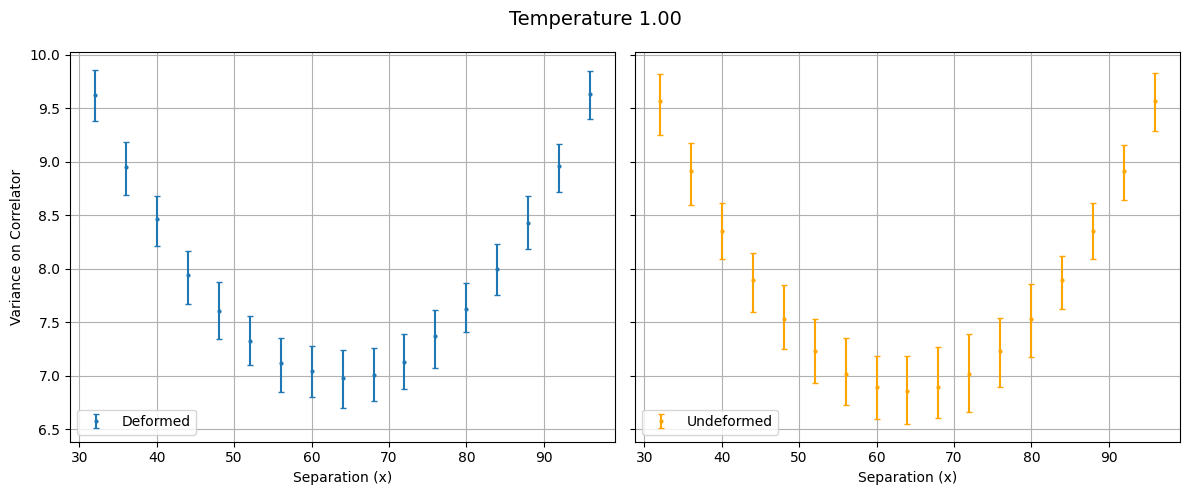

In [107]:
for i in range(0,21,5):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

    c, l, u, _ = deformed_proj_mean_CIs[i]
    axes[0].errorbar(
        x_seps,
        c,
        yerr=(c - l, u - c),
        fmt="o",
        markersize=2,  # size of the mean point
        capsize=2.5,  # caps at ends of error bars
        elinewidth=1.5,  # vertical line thickness
        capthick=1,  # cap thickness
        label='Deformed'
    )
    axes[0].grid()
    axes[0].set_xlabel('Separation (x)')
    axes[0].set_ylabel('Variance on Correlator')
    axes[0].legend()

    c, l, u, _ = undeformed_proj_mean_CIs[i]
    axes[1].errorbar(
        x_seps,
        c,
        yerr=(c - l, u - c),
        fmt="o",
        markersize=2,  # size of the mean point
        capsize=2.5,  # caps at ends of error bars
        elinewidth=1.5,  # vertical line thickness
        capthick=1,  # cap thickness
        label='Undeformed',
        color='orange'
    )
    axes[1].grid()
    axes[1].set_xlabel('Separation (x)')
    axes[1].legend()

    fig.suptitle(f'Temperature {val_temps[i]:.2f}', fontsize=14)
    # plt.yscale('log')

    plt.tight_layout()
    plt.savefig(f"writeup/figures/deformed_vs_undeformed/fig_{i//5}.png", dpi=200, bbox_inches='tight')


In [ ]:
plot_complex_histograms(
    undef_1layer[::10],
    deformed_grid[::10, :, 64, 12],
    temps=np.round(val_temps[::10], decimals=2),
    bins=50,
    cmap="viridis",
    save_dir="writeup/figures/unet_hists",
    filename_prefix="temp",
    fmt="png",
)

In [50]:
from statsmodels.tsa.stattools import acf

Text(0.5, 1.0, 'ACF Undeformed Correlator Samples')

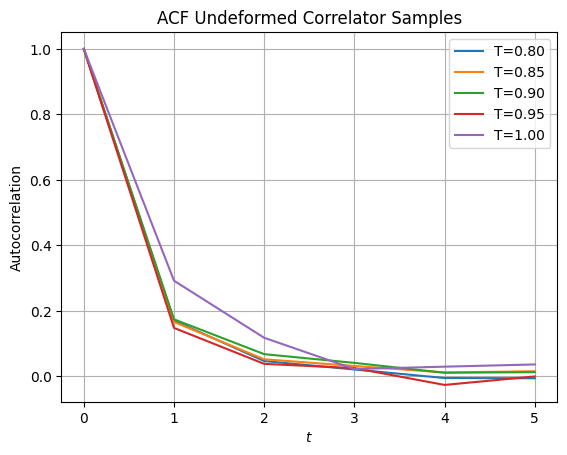

In [78]:
for i in range(0, val_temps.size, 5):
    undef_acf_vals = acf(undef_1layer[i].real, nlags=5, fft=True)
    plt.plot(undef_acf_vals, label=f"T={val_temps[i]:.2f}")

plt.legend()
plt.grid()
plt.xlabel("$t$")
plt.ylabel("Autocorrelation")
plt.title("ACF Undeformed Correlator Samples")

Text(0, 0.5, 'Autocorrelation')

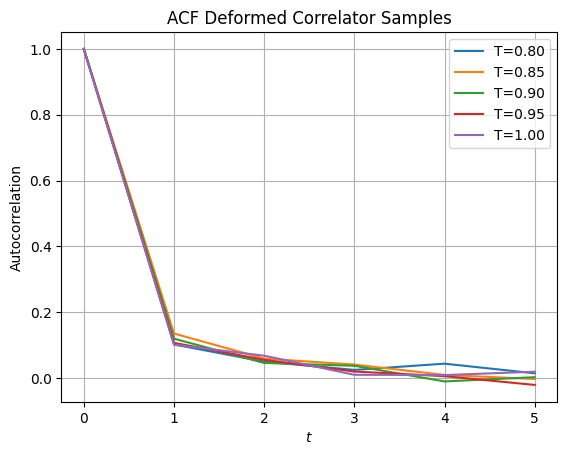

In [ ]:
for i in range(0, val_temps.size, 5):
    def_acf_vals = acf(deformed_grid[i, :, 64, 12].real, nlags=5, fft=True)
    plt.plot(def_acf_vals, label=f"T={val_temps[i]:.2f}")

plt.legend()
plt.grid()
plt.title("ACF Deformed Correlator Samples")
plt.xlabel("$t$")
plt.ylabel("Autocorrelation")

In [86]:
undeformed_proj[0].shape

(4500, 17)

In [97]:
from statsmodels.tsa.stattools import acf

var_ratio_CIs = []

for i in range(21):

    centres = np.zeros(undeformed_proj[i].shape[1])
    lowers = np.zeros(undeformed_proj[i].shape[1])
    uppers = np.zeros(undeformed_proj[i].shape[1])
    iacts = np.zeros(undeformed_proj[i].shape[1])

    for j in range(undeformed_proj[i].shape[1]):

        autocorr1 = acf(undeformed_proj[i,:,j], nlags=50, fft=True)[1:]
        autocorr2 = acf(deformed_proj[i,:,j], nlags=50, fft=True)[1:]

        n1 = autocorr1.size
        n2 = autocorr2.size

        taper1 = 1 - np.arange(1, n1 + 1) / (n1 + 1)
        taper2 = 1 - np.arange(1, n2 + 1) / (n2 + 1)

        int_act1 = 1 + 2 * np.sum(taper1 * autocorr1)
        int_act2 = 1 + 2 * np.sum(taper2 * autocorr2)

        blocksize1 = min([int(np.ceil(2 * int_act1)), len(undeformed_proj[i,:,j]) // 2])
        blocksize2 = min([int(np.ceil(2 * int_act2)), len(deformed_proj[i,:,j]) // 2])


        # print(undeformed_proj[i,:,j].shape, deformed_proj[i,:,j].shape, blocksize1, blocksize2)
        blocks1 = [undeformed_proj[i,:,j][k:k+blocksize1] for k in range(0, len(undeformed_proj[i,:,j]) - blocksize1 + 1)]
        blocks2 = [deformed_proj[i,:,j][k:k+blocksize2] for k in range(0, len(deformed_proj[i,:,j]) - blocksize2 + 1)]

        boots = np.zeros(250)

        for b in range(250):
            resampled_blocks1 = np.random.choice(len(blocks1), size=int(np.ceil(len(undeformed_proj[i,:,j]) / blocksize1)), replace = True)
            resampled_blocks2 = np.random.choice(len(blocks2), size=int(np.ceil(len(deformed_proj[i,:,j]) / blocksize2)), replace = True)
            resampled1 = np.concatenate([blocks1[i] for i in resampled_blocks1])
            resampled2 = np.concatenate([blocks2[i] for i in resampled_blocks2])
            boots[b] = np.var(resampled2) / np.var(resampled1)

        centres[j] = np.mean(boots)
        lowers[j] = np.percentile(boots, 2.5)
        uppers[j] = np.percentile(boots, 97.5)
        iacts[j] = int_act1

    var_ratio_CIs.append((centres, lowers, uppers, iacts))

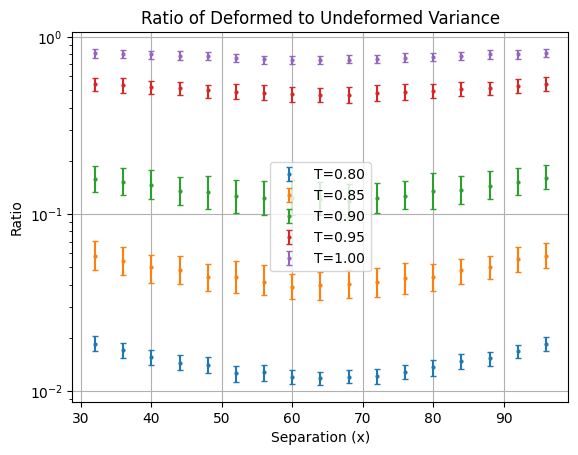

In [101]:
for i in range(0,21,5):
    # plt.figure()
    c, l, u, _ = var_ratio_CIs[i]
    plt.errorbar(
        x_seps,
        c,
        yerr=(c - l, u - c),
        fmt="o",
        markersize=2,  # size of the mean point
        capsize=2.5,  # caps at ends of error bars
        elinewidth=1.5,  # vertical line thickness
        capthick=1,  # cap thickness,
        label=f'T={val_temps[i]:.2f}',
    )
plt.grid()
plt.xlabel('Separation (x)')
plt.ylabel('Ratio')
plt.title(f'Ratio of Deformed to Undeformed Variance')
plt.legend()
plt.yscale('log')